In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning

hits = pd.read_hdf("../data/ATPC_0nubb/ATPC_0nubb_1bar_smear_1.h5", "MC/hits")

# hits = pd.read_hdf("../data/ATPC_Tl/ATPC_Tl_1bar_smear_1.h5", "MC/hits")

# hits = pd.read_hdf("../data/Trackreco/ATPC_Tl_1bar_nodiff_reco.h5", "data")


display(hits)
event_list = hits.event_id.unique()
print(event_list)


,event_id,x,y,z,energy
0,300,89.615318,-939.863159,955.390076,0.001612
1,300,91.906059,-935.204834,956.500061,0.001463
2,300,88.367668,-944.717957,956.973877,0.001017
3,300,92.731934,-933.711548,957.157471,0.000595
4,300,93.129417,-932.968079,957.531433,0.000050
...,...,...,...,...,...
61347,359,-360.404266,-1859.765991,3375.439453,0.012152
61348,359,-365.006500,-1860.799927,3376.175293,0.015847
61349,359,-367.853821,-1863.795044,3376.409912,0.007490
61350,359,-367.820679,-1862.214722,3378.310547,0.002207


[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353
 354 355 356 357 358 359]


,event_id,x,y,z,energy
0,301,982.422119,472.430359,2962.168213,0.000372
1,301,982.464844,472.606934,2962.426758,0.000025
2,301,984.418823,476.050110,2963.065186,0.003373
3,301,985.071228,473.670898,2958.771729,0.002381
4,301,986.875671,474.068390,2957.062500,0.000471
...,...,...,...,...,...
1019,301,1503.823120,881.546570,1827.805664,0.000198
1020,301,1503.889404,870.619080,1815.956299,0.001711
1021,301,1504.266235,879.680359,1825.647217,0.002331
1022,301,1504.283203,872.021484,1817.595581,0.000298


Median distance to the closest row: 2.5480535886945965


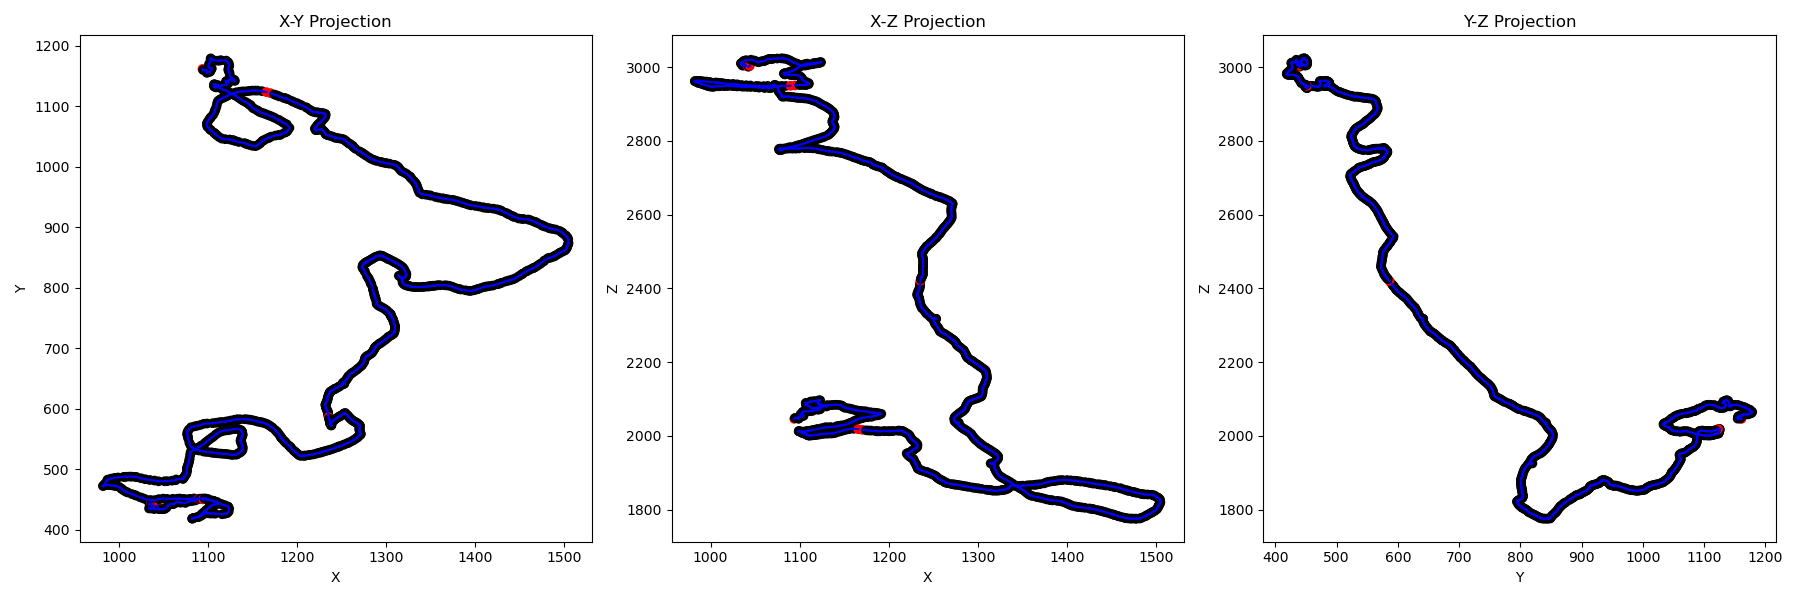

In [229]:
%matplotlib widget

data = hits[hits.event_id ==event_list[1]]
# data = hits[hits.event_id ==54648029]

# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
# eid = data.event_id.item()
data = data[['event_id', 'x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

display(data)

df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}
connections = []

# Tunable parameters
Mean_dist = GetMedianNodeDistances(data) # Median distance between nodes
init_dist_thresh = Mean_dist*2 # max distance for initial connections [mm]
incr_dist_thresh = np.linspace(1, Mean_dist*2, 15, dtype=int) # Second stage, look for closest nodes, then slowly increase threshold [mm]
incr_dist_thresh = np.unique(incr_dist_thresh)

dist_threshold = 15 # Third distance threshold for conecting end nodes [mm]


for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    # closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    closest_idx = np.argsort(dist_matrix[i])[1]
    
    # Check if the connection already exists 
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):

        # Check the proposed node has 0 or 1 connection
        if (connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and dist_matrix[i][closest_idx] < init_dist_thresh):
            
            cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
            
            # Add connection between node i and closest_idx if it doesnt form a cycle
            if (not cycle):
                connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Incrementally loop over distance steps looking for connections
# starting from a small step size helps lock onto the nearest nodes
for dist in incr_dist_thresh:

    # Connect single nodes to the next closest single node
    for i in single_nodes:
        
        # Connections get updated, so this ensures we dont make a connection to a newly formed connection
        if connection_count[i] == 1:
            
            # Find the index of the closest node with one connection (excluding itself)
            sorted_indices = np.argsort(dist_matrix[i])[1:]
            
            for closest_idx in sorted_indices[:dist]:

                # Check if the index is not itelf and the connection count of the closest index is 1
                if closest_idx != i and connection_count[closest_idx] <= 1 and connection_count[i] <= 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                    
                    if dist_matrix[i][closest_idx] < dist:

                        cycle  = Testcycle(i, closest_idx ,connected_nodes, connections, connection_count)
                        
                        if not cycle:
                            connected_nodes, connections, connection_count = UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                            break


# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_29556/518107878.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('Dark2')


{'id': 0, 'start': 43, 'end': 152, 'nodes': [43, 41, 38, 42, 45, 50, 49, 44, 37, 46, 48, 51, 59, 60, 63, 64, 67, 68, 69, 71, 73, 74, 76, 79, 80, 82, 88, 109, 118, 122, 129, 135, 141, 148, 157, 165, 181, 211, 224, 239, 251, 261, 267, 276, 294, 301, 308, 303, 289, 286, 275, 268, 233, 215, 202, 190, 176, 167, 162, 159, 155, 146, 143, 137, 134, 126, 120, 121, 123, 138, 145, 147, 156, 163, 166, 182, 189, 192, 195, 201, 217, 231, 242, 241, 226, 220, 206, 183, 178, 152], 'length': 283.68, 'energy': 0.31753920087066945, 'label': 'track', 'c': (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)}
{'id': 1, 'start': 54, 'end': 56, 'nodes': [54, 55, 56], 'length': 3.321, 'energy': 0.013912799971876666, 'label': 'track', 'c': (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)}
{'id': 3, 'start': 139, 'end': 560, 'nodes': [139, 127, 111, 90, 85, 81, 78, 72, 65, 61, 58, 53, 47, 40, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 17, 16, 14, 13, 11, 10, 8, 4, 3, 0, 1, 2, 5, 6, 7, 9, 12, 

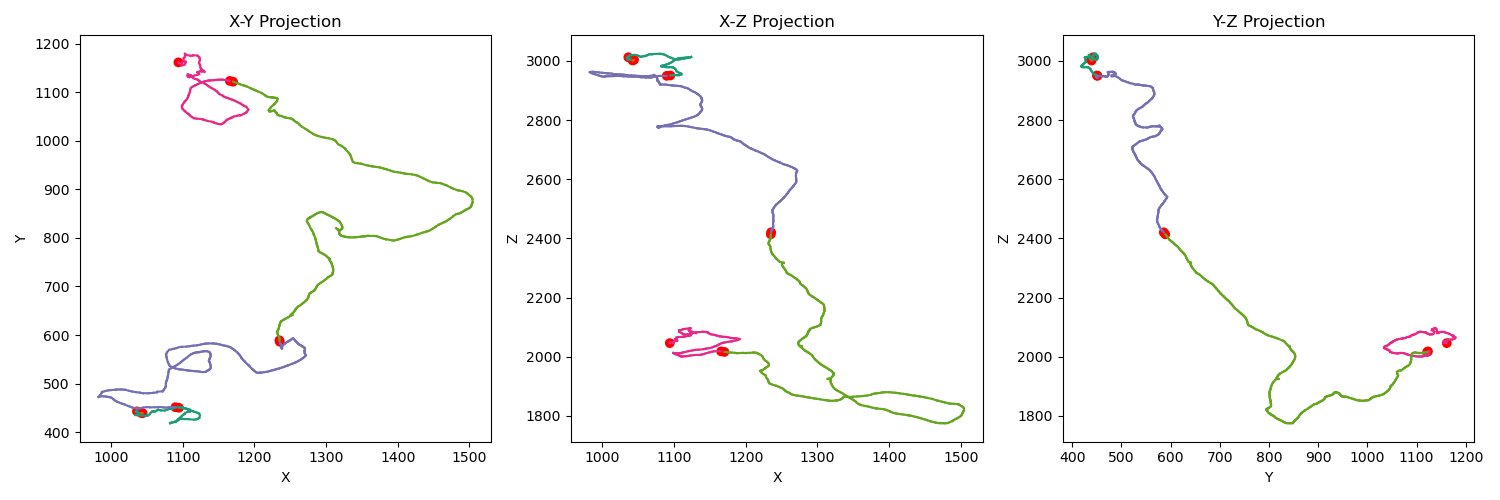

In [230]:
# Track building
colormap = plt.cm.get_cmap('Dark2')
color_cycle = itertools.cycle(colormap.colors)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]


Tracks = []

for i,node in enumerate(single_nodes):
    # Check that the track hasnt already been added
    if (check_start_end_exists(node,Tracks)):
        continue

    # Get the track path
    path = GetNodePath(connected_nodes, node, connected_nodes[node][0])

    total_length, total_energy = GetTrackLengthEnergy(path, data)
    color = next(color_cycle)

    Track = {"id":i, "start":path[0], "end":path[-1], "nodes":path, "length":total_length, "energy":total_energy,"label":"track","c":color}
    Tracks.append(Track)


for t in Tracks:
    print(t)

# Function to plot connections
def plot_tracks(ax, x, y, connection_count, x_label, y_label, Tracks_):
    # Filter data for markers with count 1 or 0
    filtered_indices = [i for i, count in enumerate(connection_count) if count == 1 or count == 0 or count == 3]
    filtered_x = [x[i] for i in filtered_indices]
    filtered_y = [y[i] for i in filtered_indices]
    
    # # Define colors for filtered data
    colors = [None] * len(filtered_indices)
    for index, i in enumerate(filtered_indices):
        if connection_count[i] == 1:
            colors[index] = "r"
        elif (connection_count[i] == 0):
            colors[index] = "Orange"
        else:
            colors[index] = "DarkGreen"

    
    # Plot filtered markers
    ax.scatter(filtered_x, filtered_y, c=colors, marker='o')

    # Plot connections
    for Track in Tracks_:
        for i, connection in enumerate(Track["nodes"]):
            if i == len(Track["nodes"]) - 1:
                break

            start_node = Track["nodes"][i]
            end_node = Track["nodes"][i + 1]

            ax.plot([x[start_node], x[end_node]],
                    [y[start_node], y[end_node]], color=Track["c"], linestyle="-")
            
        if (Track["label"] == "vertex"):
            ax.plot(x[Track["start"]], y[Track["start"]], marker = "x", color = "r" )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', Tracks)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', Tracks)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', Tracks)

plt.tight_layout()
plt.show()

In [231]:
print(GetMedianNodeDist(Tracks, data))

dist_threshold = 4*GetMedianNodeDist(Tracks, data)
print("Dist Thresh",dist_threshold)

3.275
Dist Thresh 13.1


In [232]:
# Now look to merge tracks that are close by and identify deltas

# Add in any nodes without connections to the tracks as gammas and re-label other tracks as gammas
AddConnectionlessNodes(connection_count, Tracks, data)


In [233]:

finished = False  # Initial state

q = 0
while not finished:
    print("Loop: ", q)
    # finished, Tracks2 = ConnectTracks(Tracks2, temp_connections_dict, temp_connections, temp_connection_count)
    finished, Tracks, connected_nodes, connections, connection_count = ConnectTracks(Tracks, connected_nodes, connections, connection_count, dist_matrix, dist_threshold, data)
    q=q+1

print(finished)

print("Total Tracks:", len(Tracks))

for t in Tracks:
    print(t)



Loop:  0
Loop:  1
Loop:  2
Loop:  3
True
Total Tracks: 2
{'id': 1, 'start': 54, 'end': 56, 'nodes': [50, 54, 55, 56], 'length': 3.321, 'energy': 0.013912799971876666, 'label': 'track', 'c': 'black'}
{'id': 10, 'start': 43, 'end': 150, 'nodes': [43, 41, 38, 42, 45, 50, 49, 44, 37, 46, 48, 51, 59, 60, 63, 64, 67, 68, 69, 71, 73, 74, 76, 79, 80, 82, 88, 109, 118, 122, 129, 135, 141, 148, 157, 165, 181, 211, 224, 239, 251, 261, 267, 276, 294, 301, 308, 303, 289, 286, 275, 268, 233, 215, 202, 190, 176, 167, 162, 159, 155, 146, 143, 137, 134, 126, 120, 121, 123, 138, 145, 147, 156, 163, 166, 182, 189, 192, 195, 201, 217, 231, 242, 241, 226, 220, 206, 183, 178, 152, 139, 127, 111, 90, 85, 81, 78, 72, 65, 61, 58, 53, 47, 40, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 17, 16, 14, 13, 11, 10, 8, 4, 3, 0, 1, 2, 5, 6, 7, 9, 12, 15, 19, 21, 23, 25, 27, 29, 31, 33, 35, 39, 52, 57, 62, 66, 70, 75, 77, 84, 83, 86, 87, 89, 91, 93, 94, 92, 95, 99, 102, 104, 106, 108, 110, 112, 114, 115, 124, 130, 136, 144,

{'id': 0, 'start': 43, 'end': 150, 'length': 3426.338, 'energy': 2.447561599648907, 'label': 'Primary', 'c': 'Teal', 'nodes': [43, 41, 38, 42, 45, 50, 49, 44, 37, 46, 48, 51, 59, 60, 63, 64, 67, 68, 69, 71, 73, 74, 76, 79, 80, 82, 88, 109, 118, 122, 129, 135, 141, 148, 157, 165, 181, 211, 224, 239, 251, 261, 267, 276, 294, 301, 308, 303, 289, 286, 275, 268, 233, 215, 202, 190, 176, 167, 162, 159, 155, 146, 143, 137, 134, 126, 120, 121, 123, 138, 145, 147, 156, 163, 166, 182, 189, 192, 195, 201, 217, 231, 242, 241, 226, 220, 206, 183, 178, 152, 139, 127, 111, 90, 85, 81, 78, 72, 65, 61, 58, 53, 47, 40, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 17, 16, 14, 13, 11, 10, 8, 4, 3, 0, 1, 2, 5, 6, 7, 9, 12, 15, 19, 21, 23, 25, 27, 29, 31, 33, 35, 39, 52, 57, 62, 66, 70, 75, 77, 84, 83, 86, 87, 89, 91, 93, 94, 92, 95, 99, 102, 104, 106, 108, 110, 112, 114, 115, 124, 130, 136, 144, 149, 158, 161, 171, 186, 207, 216, 234, 247, 258, 266, 274, 281, 291, 310, 320, 326, 333, 339, 342, 350, 356, 363, 36

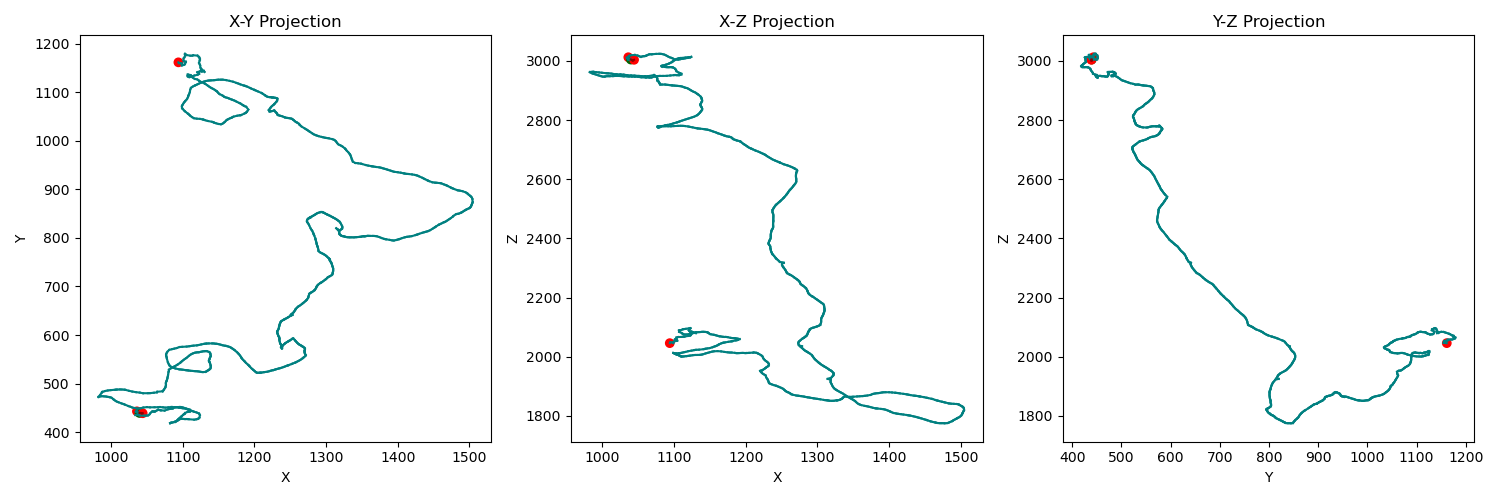

In [234]:
def RebuildTracks(connected_nodes_, connection_count_, data):

    RebuiltTrack_ = []
    Track_arrays = []
    Accounted_nodes = []
    track_nodes = []

    data_nodes = data.index.values.tolist()
    remaining_nodes = data_nodes
    trk_ids = 0
    i = 0
    
    # Loop over and build tracks
    while remaining_nodes:
        RebuildTracks_, remaining_nodes, trk_ids = MakeTracks(connection_count_, connected_nodes_, data_nodes, remaining_nodes, data, i, trk_ids, RebuiltTrack_)
        i = i + 1

    # Quality control
    track_nodes = []
    e_sum = 0
    for t in RebuiltTrack_:
        e_sum = e_sum+t["energy"]
        track_nodes = track_nodes + t["nodes"]


    ratio = e_sum / data.energy.sum()

    if (ratio < 0.999 or ratio > 1.0001):
        print("Ratio is off:", ratio)
        return RebuiltTrack_, False

    are_equal = set(track_nodes) == set(data_nodes)

    if (not are_equal):
        print("Missing Nodes:", set(data_nodes) - set(track_nodes))
        return RebuiltTrack_, False

    return RebuiltTrack_, True


def MakeTracks(connection_count_, connected_nodes_, data_nodes, remaining_nodes, data, iteration, trk_ids, RebuiltTrack_):

    Track_arrays = []

    prim_track_id = -1
    prim_len = 0
    prim_track_arr = []
    prim_energy = 0

    # Get all nodes with single connections
    end_points = np.where(connection_count_ == 1)[0]
    end_points = [x for x in end_points if x in remaining_nodes]

    if (iteration == 0):
        primary_label = "Primary"
        delta_label = "Delta"
        color = "Teal"
    else:
        primary_label = "Brem"
        delta_label = "BremDelta"
        color = next(color_cycle)

    for index, end_point in enumerate(end_points):
        trkpath = GetLongestPath(connected_nodes_, end_point)
        Track_arrays.append(trkpath)

        trk_length = GetTrackLength(trkpath, data)

        if (trk_length > prim_len):
            prim_len = trk_length
            prim_track_id = index
            prim_track_arr = trkpath
            prim_energy = GetTrackEnergy(trkpath, data, False)
    
    # Create the primary track
    RebuiltTrack_.append({"id":trk_ids, "start":prim_track_arr[0], "end":prim_track_arr[-1], "length":trk_length, "energy":prim_energy, "label":primary_label, "c":color, "nodes":prim_track_arr})
    trk_ids = trk_ids + 1

    # Get all nodes with three connections in the primary track
    multi_connections = np.where(connection_count_ == 3)[0]
    prim_track_multi_connections = [x for x in multi_connections if x in prim_track_arr]

    for node in prim_track_multi_connections:
        delta_node = [x for x in connected_nodes_[node] if x not in prim_track_arr]

        if (len(delta_node) > 1):
            print("Error the delta node has more than one node after cut")

        delta_paths = GetDeltaPath(connected_nodes_, node , delta_node[0], 0)
    
        for t in range(len(delta_paths)):
            trkpath = delta_paths[t]
            trk_energy = GetTrackEnergy(trkpath, data, True)
            trk_length = GetTrackLength(trkpath, data)
            RebuiltTrack_.append({"id":trk_ids, "start":trkpath[0], "end":trkpath[-1], "length":trk_length, "energy":trk_energy, "label":f"{delta_label}{t}", "c":"DarkRed", "nodes":trkpath})
            trk_ids = trk_ids + 1


    # This is for single nodes
    single_points = np.where(connection_count_ == 0)[0]
    single_points = [x for x in single_points if x in remaining_nodes] # Removes ones that have already been added

    for index, single_point in enumerate(single_points):
        trkpath = [single_point]
        energy = GetTrackEnergy(trkpath, data, False)
        RebuiltTrack_.append({"id":trk_ids, "start":trkpath[0], "end":trkpath[-1], "length":0, "energy":energy, "label":"Brem", "c":"Orange", "nodes":trkpath})
        trk_ids = trk_ids + 1


    track_nodes = []
    for t in RebuiltTrack_:
        track_nodes = track_nodes + t["nodes"]
    remaining_nodes = list(set(data_nodes) - set(track_nodes))

    return RebuiltTrack_, remaining_nodes, trk_ids



RebuiltTrack, pass_flag = RebuildTracks(connected_nodes, connection_count, data)

for t in RebuiltTrack:
    print(t)

print(pass_flag)


# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot xy projection
plot_tracks(axs[0], data['x'], data['y'], connection_count, 'X', 'Y', RebuiltTrack)

# Plot xz projection
plot_tracks(axs[1], data['x'], data['z'], connection_count, 'X', 'Z', RebuiltTrack)

# Plot yz projection
plot_tracks(axs[2], data['y'], data['z'], connection_count, 'Y', 'Z', RebuiltTrack)

# axs[0].scatter(data["x"].iloc[25], data["y"].iloc[25])

plt.tight_layout()
plt.show()



In [235]:
# Get the track with the most nodes, this is taken to be the primary

num_nodes = 0
primary_track_id = -1
primary_nodes = []

for t in RebuiltTrack:
    if ( len(t["nodes"]) > num_nodes):
        num_nodes = len(t["nodes"])
        primary_track_id = t["id"]
        primary_nodes = t["nodes"]

print("The primary track is: ", primary_track_id)

# This list makes sure we only have one angle per node
all_visited = []

Primary_Track = data.reindex(primary_nodes)
Primary_Track = GetAnglesDF(Primary_Track, all_visited, 1, primary_track_id)
all_visited = all_visited + primary_nodes

df_angles = pd.DataFrame()
df_angles = pd.concat([df_angles, Primary_Track], ignore_index=True)

for t in RebuiltTrack:

    trk_nodes = t["nodes"]
    if t["id"] == primary_track_id:
        continue
    else:
        
        # See if the first/last node has three connections. If it does then flip the track
        con_end = connection_count[t["nodes"][-1]]
        if (con_end == 3):
            trk_nodes = trk_nodes[::-1]
        
        trk = data.reindex(trk_nodes)

        trk = GetAnglesDF(trk, all_visited, 0, t["id"])
        all_visited = all_visited + trk_nodes
        df_angles = pd.concat([df_angles, trk], ignore_index=True)


# Primary_Track.reset_index(drop=True, inplace=True)
pd.set_option('display.max_rows', 100)
display(df_angles)

print(connected_nodes)



The primary track is:  0


,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle
0,301,1036.092651,442.887329,3012.598145,0.025941,43,1,0,0.000000,0.000000
1,301,1035.529053,442.795288,3011.790771,0.006076,41,1,0,0.988922,124.870283
2,301,1034.540894,442.108795,3010.616455,0.016194,38,1,0,2.670216,19.404605
3,301,1035.534424,443.899414,3005.448242,0.023957,42,1,0,8.229338,65.620092
4,301,1036.304932,441.527985,3004.434570,0.006274,45,1,0,10.920972,83.252536
...,...,...,...,...,...,...,...,...,...,...
1019,301,1094.646240,1159.509766,2048.530762,0.013888,151,1,0,3423.175989,66.911090
1020,301,1093.946411,1161.250977,2045.985718,0.043152,150,1,0,3426.338081,74.071537
1021,301,1042.067993,439.375824,3001.604248,0.002902,54,0,1,3.993405,137.211515
1022,301,1042.794800,438.881805,3002.053955,0.000248,55,0,1,4.980592,84.190290


{0: [1, 3], 1: [0, 2], 2: [1, 5], 3: [4, 0], 4: [3, 8], 5: [6, 2], 6: [5, 7], 7: [6, 9], 8: [10, 4], 10: [8, 11], 9: [7, 12], 11: [10, 13], 12: [9, 15], 13: [14, 11], 14: [13, 16], 15: [12, 19], 16: [14, 17], 17: [18, 16], 18: [17, 20], 19: [21, 15], 21: [19, 23], 20: [22, 18], 22: [20, 24], 23: [21, 25], 24: [22, 26], 25: [27, 23], 27: [25, 29], 26: [28, 24], 28: [26, 30], 30: [28, 32], 29: [31, 27], 31: [29, 33], 32: [34, 30], 34: [32, 36], 33: [35, 31], 35: [33, 39], 36: [34, 40], 37: [44, 46], 44: [37, 49], 38: [41, 42], 41: [38, 43], 40: [47, 36], 47: [40, 53], 43: [41], 42: [45, 38], 45: [42, 50], 49: [44, 50], 46: [48, 37], 48: [46, 51], 50: [49, 45, 54], 51: [48, 59], 52: [57, 39], 57: [52, 62], 53: [47, 58], 54: [55, 50], 55: [54, 56], 56: [55], 58: [53, 61], 59: [60, 51], 60: [59, 63], 63: [60, 64], 61: [65, 58], 65: [61, 72], 62: [66, 57], 66: [62, 70], 64: [63, 67], 67: [68, 64], 68: [67, 69], 69: [68, 71], 71: [69, 73], 70: [75, 66], 75: [70, 77], 72: [78, 65], 78: [72, 81

Text(0, 0.5, 'Scatter Angle [deg]')

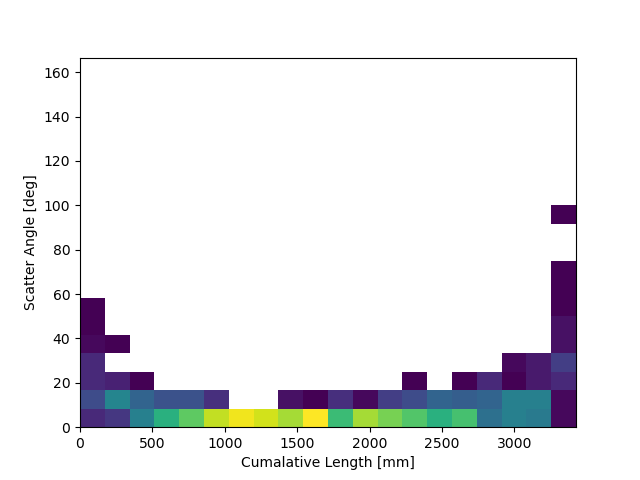

In [236]:
plt.figure()
# plt.scatter(Primary_Track.x, Primary_Track.z)

# plt.scatter(Primary_Track.index, Primary_Track.angle)

# plt.hist(Primary_Track.angle)
# plt.semilogy()
plt.hist2d(Primary_Track.cumulative_distance, Primary_Track.angle, bins = 20,cmin=3);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle);

# plt.scatter(Primary_Track.cumulative_distance, Primary_Track.angle)

plt.xlabel("Cumalative Length [mm]")
plt.ylabel("Scatter Angle [deg]")

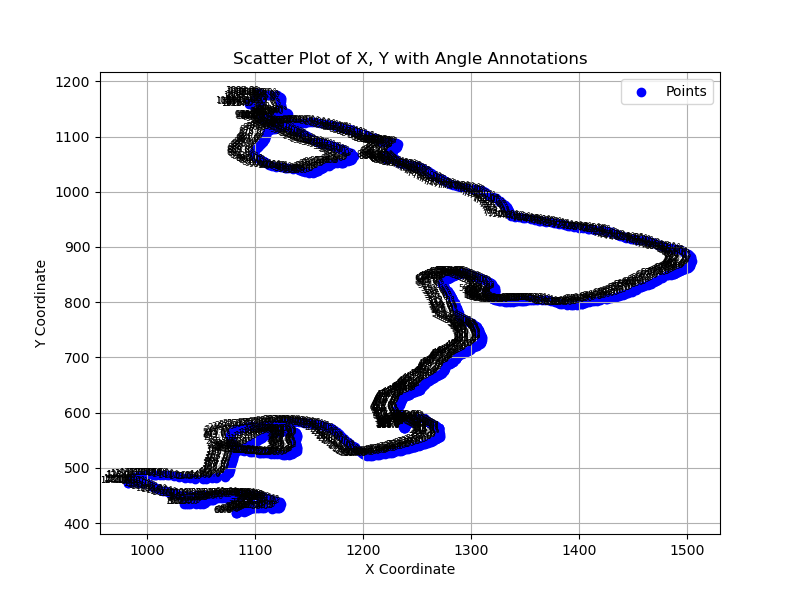

In [237]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Primary_Track['x'], Primary_Track['y'], color='blue', label='Points')

# Annotate each point with the corresponding angle
for i in range(len(Primary_Track)):
    x = Primary_Track.iloc[i]['x']
    y = Primary_Track.iloc[i]['y']
    # angle = Primary_Track.loc[i, 'angle']
    angle = i
    
    # Only annotate if angle is not NaN
    if not np.isnan(angle):
        plt.text(x, y, f'{angle:.1f}°', fontsize=6, ha='right')

# Additional plot settings
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of X, Y with Angle Annotations')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [238]:
# Calculate Track Tortuosity

df_angles = CalcTortuosity(df_angles)

In [239]:
display(df_angles)

,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle,Tortuosity
0,301,1036.092651,442.887329,3012.598145,0.025941,43,1,0,0.000000,0.000000,3.134869
1,301,1035.529053,442.795288,3011.790771,0.006076,41,1,0,0.988922,124.870283,2.791129
2,301,1034.540894,442.108795,3010.616455,0.016194,38,1,0,2.670216,19.404605,2.754219
3,301,1035.534424,443.899414,3005.448242,0.023957,42,1,0,8.229338,65.620092,2.773225
4,301,1036.304932,441.527985,3004.434570,0.006274,45,1,0,10.920972,83.252536,2.857166
...,...,...,...,...,...,...,...,...,...,...,...
1019,301,1094.646240,1159.509766,2048.530762,0.013888,151,1,0,3423.175989,66.911090,2.235924
1020,301,1093.946411,1161.250977,2045.985718,0.043152,150,1,0,3426.338081,74.071537,2.270145
1021,301,1042.067993,439.375824,3001.604248,0.002902,54,0,1,3.993405,137.211515,1.051180
1022,301,1042.794800,438.881805,3002.053955,0.000248,55,0,1,4.980592,84.190290,1.051180


1021


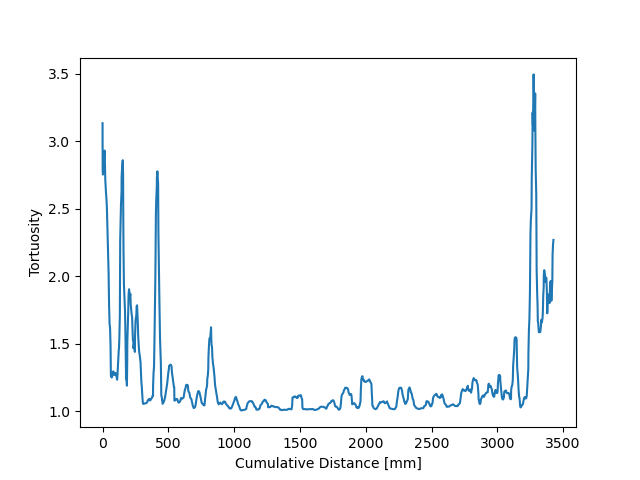

In [240]:
plt.figure()

plt.plot(df_angles[df_angles.trkID == 0].cumulative_distance, df_angles[df_angles.trkID == 0]["Tortuosity"])
plt.xlabel("Cumulative Distance [mm]")
plt.ylabel("Tortuosity")

# plt.figure()

# plt.hist(df_angles[df_angles.trkID == 0].cumulative_distance, weights = df_angles[df_angles.trkID == 0].energy, bins = 20)
# plt.xlabel("Cumulative Distance [mm]")
# plt.ylabel("Energy [MeV]")


print(len(df_angles[df_angles.trkID == 0]))

Window: 11
Window: 5


,event_id,x,y,z,energy,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
0,301,1036.092651,442.887329,3012.598145,0.025941,43,1,0,0.000000,0.000000,3.134869,3.006171
1,301,1035.529053,442.795288,3011.790771,0.006076,41,1,0,0.988922,124.870283,2.791129,2.820794
2,301,1034.540894,442.108795,3010.616455,0.016194,38,1,0,2.670216,19.404605,2.754219,3.145598
3,301,1035.534424,443.899414,3005.448242,0.023957,42,1,0,8.229338,65.620092,2.773225,3.465945
4,301,1036.304932,441.527985,3004.434570,0.006274,45,1,0,10.920972,83.252536,2.857166,3.843073
...,...,...,...,...,...,...,...,...,...,...,...,...
1019,301,1094.646240,1159.509766,2048.530762,0.013888,151,1,0,3423.175989,66.911090,2.235924,2.424516
1020,301,1093.946411,1161.250977,2045.985718,0.043152,150,1,0,3426.338081,74.071537,2.270145,2.395889
1021,301,1042.067993,439.375824,3001.604248,0.002902,54,0,1,3.993405,137.211515,1.051180,0.182703
1022,301,1042.794800,438.881805,3002.053955,0.000248,55,0,1,4.980592,84.190290,1.051180,0.182703


Text(0, 0.5, 'Squiglicity')

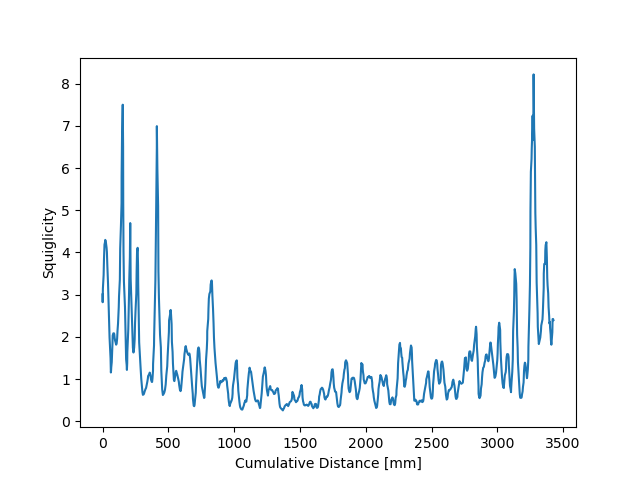

In [241]:

# Step 3: Compute perpendicular distances
def point_to_line_distance(P, A, D):
    return np.linalg.norm(np.cross(P - A, D)) / np.linalg.norm(D)

def CalcSquiglicity(df_angles):

    # df_angles['distance_diff'] = df_angles.groupby(['event_id', 'trkID'])['cumulative_distance'].diff().fillna(0)

    df_angles["Squiglicity"] = 1.0

    Squiglicity = []

    window = 10

    for trkID in df_angles.trkID.unique():

        # Get the track
        trk_df = df_angles[df_angles.trkID == trkID]

        # Try to dynamically calculate the window size by splitting into 100 pieces
        window = int(len(trk_df)/100 + 1)
        if window < 5:
            window = 5
        print("Window:",window)

        # Loop over the nodes in the track
        for index in range(len(trk_df)):

            start = max(0, index - window)  # Prevent going below index 0
            end = min(len(trk_df), index + window + 1)  # Prevent exceeding last index
            
            temp_df = trk_df.iloc[start:end]

            point1 = temp_df.iloc[0]
            point2 = temp_df.iloc[-1]
            segment_length = calculate_distance(point1, point2)

            # Avoids division by zero
            if (segment_length == 0):
                segment_length = 1


            points = temp_df[['x', 'y', 'z']].values # Get the points
            
            # Step 1: Compute centroid (a point on the best-fit line)
            A = np.mean(points, axis=0)
           
            # Step 2: Compute best-fit direction vector using SVD
            U, S, Vt = np.linalg.svd(points - A)
            D = Vt[0]  # First right-singular vector (best-fit direction)

            temp_df['distance_to_line'] = [point_to_line_distance(P, A, D) for P in points]

            # Step 4: Sum of distances
            cum_distance = temp_df['distance_to_line'].sum()

            Squiglicity.append(cum_distance/segment_length)

    df_angles["Squiglicity"] = Squiglicity

    return df_angles


df_angles = CalcSquiglicity(df_angles)
display(df_angles)


plt.figure()
plt.plot(df_angles[df_angles.trkID == 0].cumulative_distance, df_angles[df_angles.trkID == 0]["Squiglicity"])
plt.xlabel("Cumulative Distance [mm]")
plt.ylabel("Squiglicity")


In [242]:

Track_df = GetTrackdf(df_angles, RebuiltTrack, 500, 200)

display(Track_df)

print(Track_df.energy.sum())



Swapping blob names
Swapping blob names


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,Tortuosity1,Tortuosity2,label
0,301,0,1,43,150,3426.338,2.447562,0.470778,0.443920,2.10580,1.877239,Primary
0,301,1,0,50,56,7.314,0.013913,0.013913,0.013913,1.05118,1.051180,Delta0


2.4614743996207835


In [243]:

Track_df_u = UpdateTrackMeta(Track_df, df_angles, 100)

display(Track_df_u)


Adding Delta0 energy to blob1 as dist was 9.213703155517578


,event_id,trkID,primary,start,end,length,energy,blob1,blob2,Tortuosity1,Tortuosity2,label
0,301,0,1,43,150,3426.338,2.447562,0.484691,0.443920,1.57849,0.93862,Primary
0,301,1,0,50,56,7.314,0.013913,0.013913,0.013913,1.05118,1.05118,Delta0
